In [2]:
import pandas as pd
import os

# activate output for values of multiple statements at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
df = pd.read_csv(os.getcwd()+"/data/day.csv")
df["dteday"] = pd.to_datetime(df["dteday"])
df.sort_values(by="dteday",ascending=True)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
df.shape

(731, 16)

In [5]:
df.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

# Explorative data analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

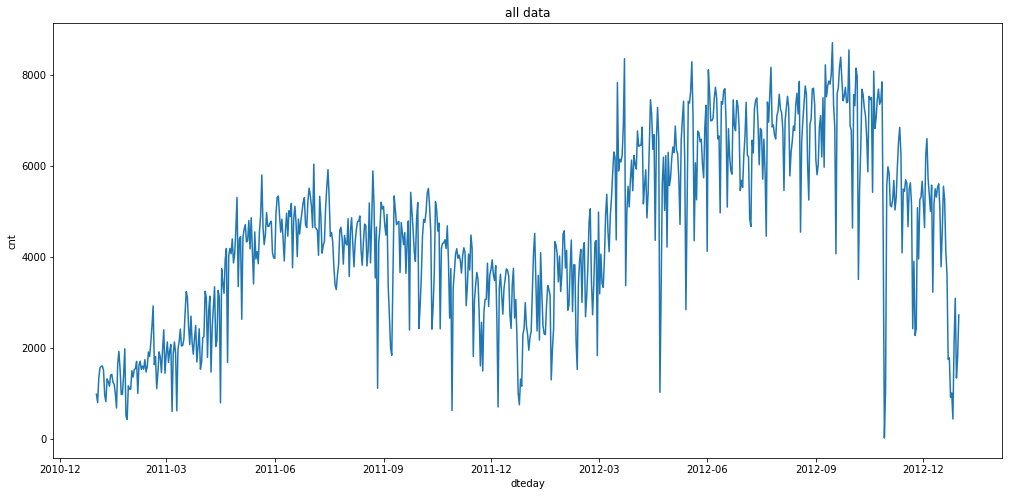

In [7]:
f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", data=df) # Plot the response over time
plt.title("all data")
plt.show(g)

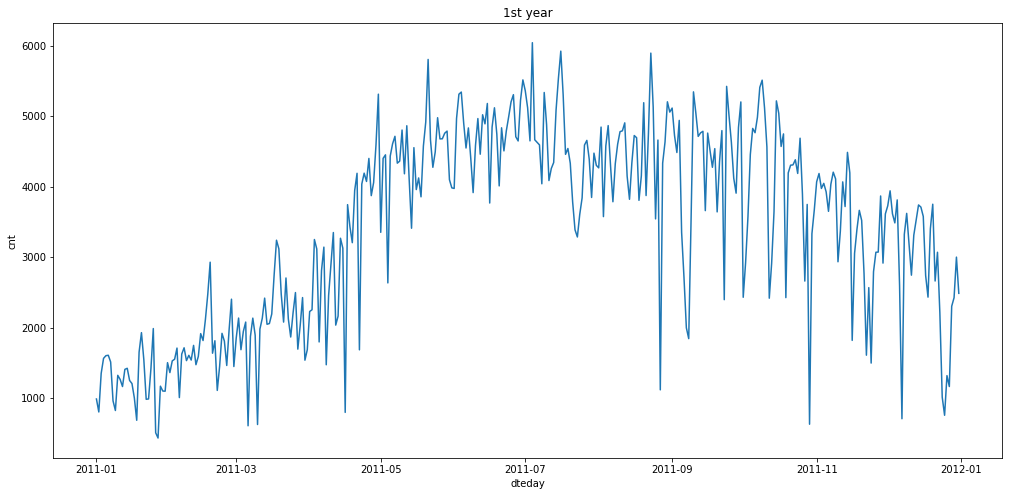

In [8]:
f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", data=df[df["yr"]==0]) # Plot the response over time
plt.title("1st year")
plt.show(g)

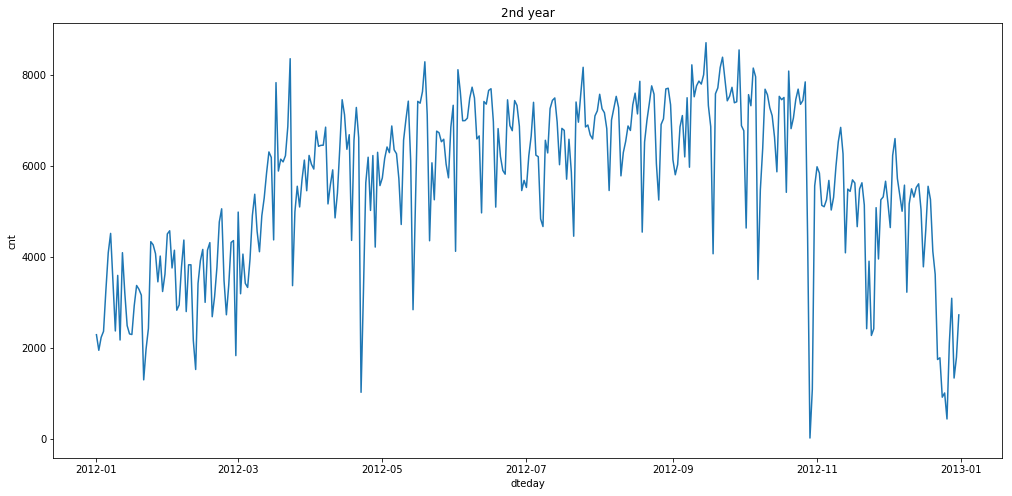

In [9]:
f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", data=df[df["yr"]==1]) # Plot the response over time
plt.title("2nd year")
plt.show(g)

# Step 1: Make data stationary

The first step in time series modeling is to remove the effects of the trend or season that exist within the data to make it stationary. Statistical modeling methods assume or require the time series to be stationary to be effective.

## What is Stationarity?

A stationary series is one where the mean of the series is no longer a function of time. With trending data, as time increase the mean of the series either increases or decreases with time (think of the steady increase in housing prices over time). For seasonal data, the mean of the series fluctuates in accordance with the season (think of the increase and decrease in temperature every 24 hours).

## Stationary Time Series and Forecasting

Should you make your time series stationary?

Generally, yes.

If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.

Statistical time series methods and even modern machine learning methods will benefit from the clearer signal in the data.

But…

We turn to machine learning methods when the classical methods fail. When we want more or better results. We cannot know how to best model unknown nonlinear relationships in time series data and some methods may result in better performance when working with non-stationary observations or some mixture of stationary and non-stationary views of the problem.

The suggestion here is to treat properties of a time series being stationary or not as another source of information that can be used in feature engineering and feature selection on your time series problem when using machine learning methods.

## How do we achieve stationarity?

There are two methods that can be applied to achieve stationarity, difference the data or linear regression.

https://www.kdnuggets.com/2018/03/time-series-dummies-3-step-process.html  
https://machinelearningmastery.com/time-series-data-stationary-python/

# Is our data stationary or non-stationary?

In [10]:
# to check, run the augmented Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["cnt"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.877448
p-value: 0.342743
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


**We fail to reject H0 => our data is non-stationary and has to be transformed!**

# Plotting a diagonal correlation matrix
Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=correlation%20matrix

In [11]:
%matplotlib inline

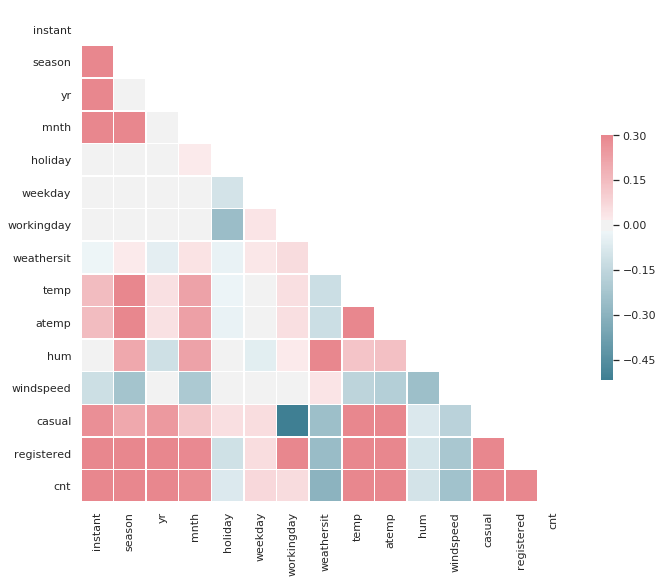

In [12]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Train-Test-Split

In [24]:
y = df["cnt"]
X = df.iloc[:,2:13] # not using columns #1 (instant = record idx) and #2 (dteday = date) as predictors
print(list(X))

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']


In [42]:
test_idx = df[(df["yr"]==1) & (df["mnth"]>5)].index

X_test=X.iloc[test_idx,]
y_test=y.iloc[test_idx,]

X_train=X.drop(test_idx)
y_train=y.drop(test_idx)

X_test.shape
X_train.shape
df.shape

(214, 11)

(517, 11)

(731, 16)

In [44]:
# it is best to apply ridge regression after standardizing the predictors!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

"Very often, the independent variables are centered and scaled in order to have variance 1."  
(Source: https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression) 


# Ridge regression

In [45]:
from sklearn import linear_model
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train) 

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [47]:
reg.coef_
reg.intercept_

array([ 398.13823377,  965.48476263,   34.9905964 ,  -72.85254894,
        103.18800454,   15.28416776, -287.82758704,  192.11640942,
        765.72768859, -162.99604511, -194.53390206])

3825.818181818182

In [48]:
from sklearn.metrics import mean_squared_error 
y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

1283454.9254171255

In [49]:
from sklearn.metrics import r2_score
r2_score(y_train, reg.predict(X_train))

0.7850137544386581

## Plot test vs. pred

Text(0.5,1,'test vs. pred')

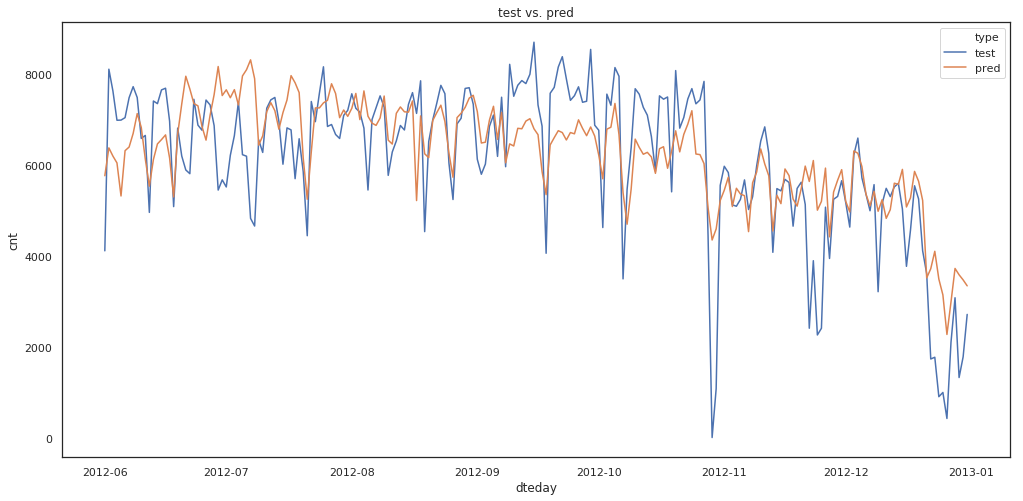

In [72]:
# prepare data for plotting (convert into long format)
test = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_test,
                         "type":"test"})
pred = pd.DataFrame({"dteday":df.iloc[test_idx,]["dteday"],
                         "cnt":y_pred,
                         "type":"pred"})
long_data=test.append(pred, ignore_index=True)

f, ax = plt.subplots(figsize=(17,8)) # Create a figure and one subplot
g=sns.lineplot(x="dteday", y="cnt", hue="type", data=long_data) # Plot the response over time
plt.title("test vs. pred")
plt.show(g)

# Ridge regression - cross validated automatically

In [116]:
from sklearn import linear_model
rcv = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5)
rcv.fit(X_train, y_train)
rcv.alpha_                                      

10.0

In [117]:
y_pred = rcv.predict(X_test)
mean_squared_error(y_test, y_pred)

20146.225189886038

In [118]:
from sklearn.metrics import r2_score
r2_score(y_train, rcv.predict(X_train))

0.370391446794891

# Ridge Regression - cross validated manually
Source: https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/

In [122]:
from sklearn.model_selection import cross_val_score

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

val_errors = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=.5, random_state=42)
    errors = np.sum(-cross_val_score(ridge, 
                                     X_train, 
                                     y=y_train, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10, 
                                     n_jobs=-1))
    val_errors.append(np.sqrt(errors))

Let’s checkout the validation errors associated with each alpha.

In [127]:
# RMSE
print(val_errors)

[455.05797081897452, 455.05797081897452, 455.05797081897452, 455.05797081897452, 455.05797081897452, 455.05797081897452]


Which value of alpha gave us the smallest validation error?

In [128]:
print('best alpha: {}'.format(alphas[np.argmin(val_errors)]))

best alpha: 0.0001


# Plot Ridge coefficients as a function of the regularization
Source: http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py

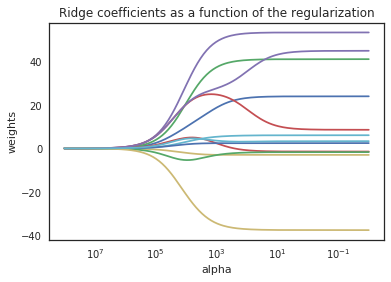

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-2, 8, n_alphas)

coefs = []
for a in alphas:
    #ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# Further Soruces:
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html  
https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/  
https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b  
https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html